### Streaming With LangGraph...

In [1]:
from typing_extensions import TypedDict               ## TypedDict -> Dict with Type Hints
from typing import Annotated                          ## Annotated -> Type Hints with Metadata

from langgraph.graph import StateGraph, START, END    ## StateGraph -> Graph API
from langgraph.checkpoint.memory import MemorySaver   ## MemorySaver -> Save StateGraph State
from langgraph.graph.message import add_messages      ## Reducer -> Append Instead of Overwrite

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]  ## Messages -> List of Dicts with Metadata

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [4]:
from langchain_groq import ChatGroq

llm  = ChatGroq(model="llama-3.3-70b-versatile")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021813AFF5F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021813B783B0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

Same LLM But With Different Way ->

In [5]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama-3.3-70b-versatile")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021813CC8EC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021813CC93D0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
def superbot(state: State):
    return {
        "messages": [llm.invoke(state["messages"])]
    }

In [7]:
## Define The Memory Saver
memory = MemorySaver()

In [8]:
## Initialize the StateGraph with the defined state
graph_builder = StateGraph(State)

In [9]:
## ADD the chatbot function as Node to the graph
graph_builder.add_node("LLMSuperBot", superbot)

In [10]:
## ADD Edges to the graph
graph_builder.add_edge(START, "LLMSuperBot")
graph_builder.add_edge("LLMSuperBot", END)

In [11]:
## Let's Compile the graph
graph = graph_builder.compile(checkpointer=memory)

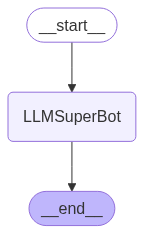

In [12]:
## Let's visualize the graph
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [14]:
## Invocation
config = {
    "configurable": {"thread_id": "1"}
}

graph.invoke({
    "messages": "Hello, My name is Mohamed and I Love LangGraph!"
}, config=config)

{'messages': [HumanMessage(content='Hello, My name is Mohamed and I Love LangGraph!', additional_kwargs={}, response_metadata={}, id='d59a16d8-aca1-492c-9fef-502779ad2500'),
  AIMessage(content="Hello Mohamed, it's nice to meet you. LangGraph is an impressive tool, and it's great to hear that you love it. What do you like most about LangGraph? Is there something specific that you've been able to accomplish with it, or a particular feature that you find really useful? I'm here to chat and help with any questions you might have.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 47, 'total_tokens': 123, 'completion_time': 0.174099005, 'prompt_time': 0.013968366, 'queue_time': 0.084593148, 'total_time': 0.188067371}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--960faae6-5f41-49bc-912d-d60f847e41ba-0', usage_metadata={'input_

#### Streaming
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [15]:
## Create a Thread
config = {
    "configurable": {"thread_id": "1"}
}

for chunk in graph.stream({
    "messages": "Hello, My name is Mohamed and I Love LangGraph!"
}, config=config, stream_mode="updates"):
    print(chunk)


{'LLMSuperBot': {'messages': [AIMessage(content="Hello again Mohamed! It's great to see your enthusiasm for LangGraph. What is it about LangGraph that you enjoy the most? Is it the conversational AI, the language understanding, or something else entirely? I'm all ears and happy to chat with you about it!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 144, 'total_tokens': 201, 'completion_time': 0.145831537, 'prompt_time': 0.018401941, 'queue_time': 0.08772134399999999, 'total_time': 0.164233478}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_e91e6fbd56', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4becbf70-e768-4e98-8b9c-957ac86b3708-0', usage_metadata={'input_tokens': 144, 'output_tokens': 57, 'total_tokens': 201})]}}


In [16]:
for chunk in graph.stream({
    "messages": "Hello, My name is Mohamed and I Love LangGraph!"
}, config=config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hello, My name is Mohamed and I Love LangGraph!', additional_kwargs={}, response_metadata={}, id='d59a16d8-aca1-492c-9fef-502779ad2500'), AIMessage(content="Hello Mohamed, it's nice to meet you. LangGraph is an impressive tool, and it's great to hear that you love it. What do you like most about LangGraph? Is there something specific that you've been able to accomplish with it, or a particular feature that you find really useful? I'm here to chat and help with any questions you might have.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 47, 'total_tokens': 123, 'completion_time': 0.174099005, 'prompt_time': 0.013968366, 'queue_time': 0.084593148, 'total_time': 0.188067371}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--960faae6-5f41-49bc-912d-d60f847e41ba-0', usage_metadata={'input_to

In [17]:
## Create a Thread
config = {
    "configurable": {"thread_id": "2"}
}

for chunk in graph.stream({
    "messages": "Hello, My name is Mohamed and I Love LangGraph!"
}, config=config, stream_mode="updates"):
    print(chunk)


{'LLMSuperBot': {'messages': [AIMessage(content="Hello Mohamed, it's nice to meet you. LangGraph is an interesting topic, what specifically do you love about it? Are you using it for a project or just exploring its capabilities? I'm here to help and chat about LangGraph if you'd like.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 47, 'total_tokens': 101, 'completion_time': 0.136272905, 'prompt_time': 0.012887467, 'queue_time': 0.086329761, 'total_time': 0.149160372}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c9185803-6385-4826-b86a-e74f091e7a02-0', usage_metadata={'input_tokens': 47, 'output_tokens': 54, 'total_tokens': 101})]}}


In [19]:
for chunk in graph.stream({
    "messages": "I Also Love CrewAI and AutoGen!"
}, config=config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hello, My name is Mohamed and I Love LangGraph!', additional_kwargs={}, response_metadata={}, id='abd3a3c6-479f-4fd1-87b8-994c2b715011'), AIMessage(content="Hello Mohamed, it's nice to meet you. LangGraph is an interesting topic, what specifically do you love about it? Are you using it for a project or just exploring its capabilities? I'm here to help and chat about LangGraph if you'd like.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 47, 'total_tokens': 101, 'completion_time': 0.136272905, 'prompt_time': 0.012887467, 'queue_time': 0.086329761, 'total_time': 0.149160372}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c9185803-6385-4826-b86a-e74f091e7a02-0', usage_metadata={'input_tokens': 47, 'output_tokens': 54, 'total_tokens': 101}), HumanMessage(content='I Also Love CrewAI and A

In [20]:
## Create a Thread
config = {
    "configurable": {"thread_id": "3"}
}

async for event in graph.astream_events({
    "messages": "Hello, My name is Mohamed and I Love LangGraph!"
}, config=config, version="v2"):
    print(event)


{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hello, My name is Mohamed and I Love LangGraph!'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'd36ed098-a388-40cd-a72a-6f206b9b406c', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hello, My name is Mohamed and I Love LangGraph!', additional_kwargs={}, response_metadata={}, id='56164ed4-2e50-40b4-86a2-975dffe1017d')]}}, 'name': 'LLMSuperBot', 'tags': ['graph:step:1'], 'run_id': 'fc0de458-12a6-4088-870a-4760f36d8663', 'metadata': {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'LLMSuperBot', 'langgraph_triggers': ('branch:to:LLMSuperBot',), 'langgraph_path': ('__pregel_pull', 'LLMSuperBot'), 'langgraph_checkpoint_ns': 'LLMSuperBot:85a1179a-2781-daad-7fce-0420542de932'}, 'parent_ids': ['d36ed098-a388-40cd-a72a-6f206b9b406c']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hello, My name is Moha

In [21]:
async for event in graph.astream_events({
    "messages": "I Also Live Computer Vision ang Generative AI!"
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'I Also Live Computer Vision ang Generative AI!'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'b9764dc5-d8fa-4cf8-bdc1-d440f0738889', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hello, My name is Mohamed and I Love LangGraph!', additional_kwargs={}, response_metadata={}, id='56164ed4-2e50-40b4-86a2-975dffe1017d'), AIMessage(content="Hello Mohamed! It's great to meet you! LangGraph is an amazing tool, and I'm glad to hear you're a fan. What do you love most about LangGraph? Is there a particular feature or aspect that you find especially useful or interesting? I'm here to chat, so feel free to share your thoughts!", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'service_tier': 'on_demand'}, id='run--9d5eb87a-3b23-4604-93cb-af2d4f9bf750', usage